Part 1 — Exploratory Data Analysis (Login Demand)

Objective

Understand temporal demand patterns by aggregating login events into 15-minute intervals and identifying cyclical behavior.

Load and Prepare Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load login data
logins = pd.read_json("logins.json")

# Convert to datetime
logins['login_time'] = pd.to_datetime(logins['login_time'])

# Set index
logins = logins.set_index('login_time')

logins.head()


""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


Aggregate into 15-Minute Intervals

In [3]:
logins_15min = logins.resample("15min").size().rename("login_count")
logins_15min.head()


login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, Name: login_count, dtype: int64

Overall Login Time Series

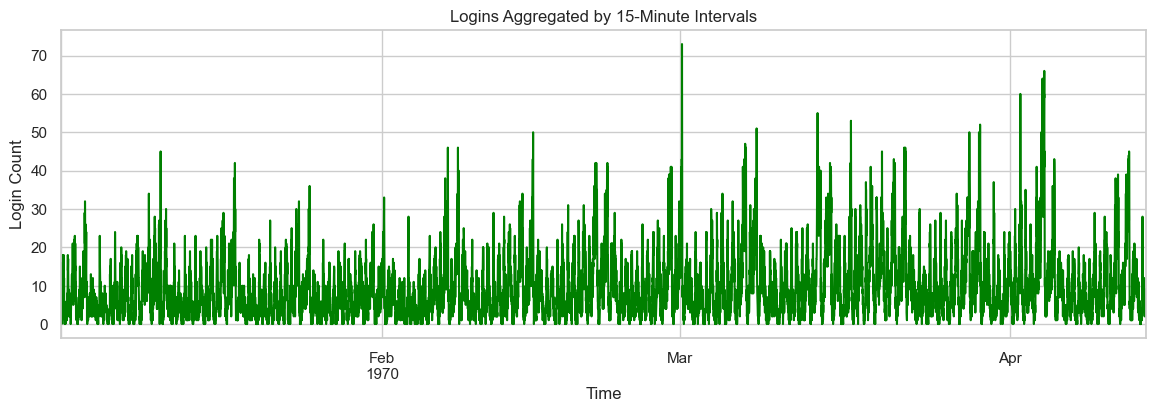

In [15]:
plt.figure(figsize=(14,4))
logins_15min.plot(color='green')
plt.title("Logins Aggregated by 15-Minute Intervals")
plt.xlabel("Time")
plt.ylabel("Login Count")
plt.show()


Average Daily Cycle

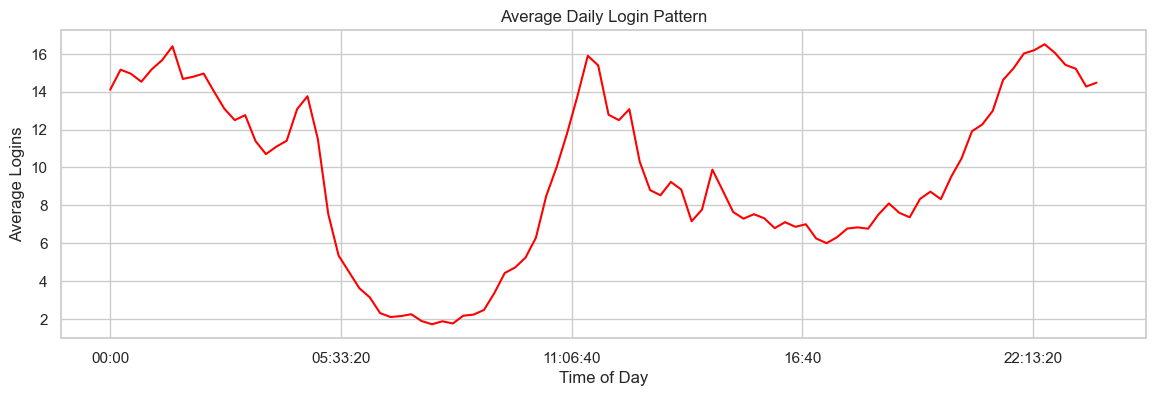

In [16]:
df_15 = logins_15min.reset_index()
df_15['time_of_day'] = df_15['login_time'].dt.time

avg_daily = df_15.groupby("time_of_day")['login_count'].mean()

plt.figure(figsize=(14,4))
avg_daily.plot(color='red')
plt.title("Average Daily Login Pattern")
plt.xlabel("Time of Day")
plt.ylabel("Average Logins")
plt.show()


Weekday vs Weekend Behavior

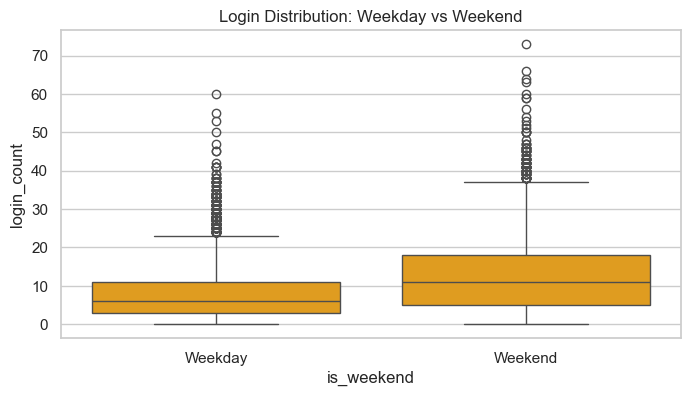

In [17]:
df_15['is_weekend'] = df_15['login_time'].dt.weekday >= 5

plt.figure(figsize=(8,4))
sns.boxplot(x='is_weekend', y='login_count', data=df_15, color='orange')
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.title("Login Distribution: Weekday vs Weekend")
plt.show()


Data Quality Checks

In [7]:
logins_15min.isna().sum()


0

Findings:

Strong daily periodicity,
Clear weekday/weekend differences,
No significant missing data issues

Part 2 — Experiment & Metrics Design (Conceptual)

Key Metric of Success:

Cross-city driver participation rate,
Percentage of drivers completing trips in both cities within a defined period (e.g., week)

Why this metric:

Directly measures behavioral change,
Aligned with supply flexibility goals,
Resistant to demand noise

Experiment Design:

Implementation:
Randomized controlled trial at driver level,
Treatment: toll reimbursement,
Control: standard tolls,
Duration: 4–6 weeks,
Stratified by baseline activity

Statistical Tests:

Two-sample proportion test,
Logistic regression controlling for driver history,
Secondary metrics: earnings/hour, idle time,

Interpretation:

Significant lift → roll out program,
No lift → try partial reimbursement or time-based incentives,

Caveats:

Spillover effects,
Short-term novelty bias,
Cross-city demand imbalance

Part 3 — Predictive Modeling (Rider Retention)

Load and Clean Data

In [8]:
import numpy as np

df = pd.read_json("ultimate_data_challenge.json")

# Convert dates
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Define retention
df['retained'] = (
    df['last_trip_date'] >= df['last_trip_date'].max() - pd.Timedelta(days=30)
)

df['retained'].mean()


0.37608

Handle Missing Values & Encoding

In [9]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)


C:\Users\pande\AppData\Local\Temp\ipykernel_40384\2463206424.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
C:\Users\pande\AppData\Local\Temp\ipykernel_40384\2463206424.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

features = [
    'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
    'surge_pct', 'avg_surge', 'trips_in_first_30_days',
    'ultimate_black_user', 'weekday_pct'
]

X = df[features]
y = df['retained']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


XGBoost Model

Why XGBoost?

Captures nonlinear effects,
Handles feature interactions,
Strong performance on tabular data

Train Model

In [12]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   --- ------------------------------------ 6.8/72.0 MB 38.1 MB/s eta 0:00:02
   -------- ------------------------------- 15.5/72.0 MB 40.5 MB/s eta 0:00:02
   ------------- -------------------------- 24.6/72.0 MB 42.2 MB/s eta 0:00:02
   ------------------ --------------------- 33.3/72.0 MB 42.3 MB/s eta 0:00:01
   ----------------------- ---------------- 41.9/72.0 MB 41.7 MB/s eta 0:00:01
   -------------------------- ------------- 48.0/72.0 MB 39.7 MB/s eta 0:00:01
   -------------------------------- ------- 58.2/72.0 MB 40.7 MB/s eta 0:00:01
   ---------------------------------- ----- 61.9/72.0 MB 37.9 MB/s eta 0:00:01
   -------------------------------------- - 69.7/72.0 MB 38.0 MB/s eta 0:00:01
   ---------------------------------------  71.8/72.0 MB 38.2 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 34.2 MB/s eta 0:00:00


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

y_prob = xgb.predict_proba(X_test)[:,1]
y_pred = xgb.predict(X_test)

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.8118147026732134
              precision    recall  f1-score   support

       False       0.77      0.86      0.81      7800
        True       0.71      0.58      0.64      4700

    accuracy                           0.75     12500
   macro avg       0.74      0.72      0.73     12500
weighted avg       0.75      0.75      0.75     12500



The model achieves a ROC AUC of 0.81 and is particularly strong at identifying users at risk of churn, making it well suited for targeted retention interventions.

Feature Importance
Gain-Based Importance

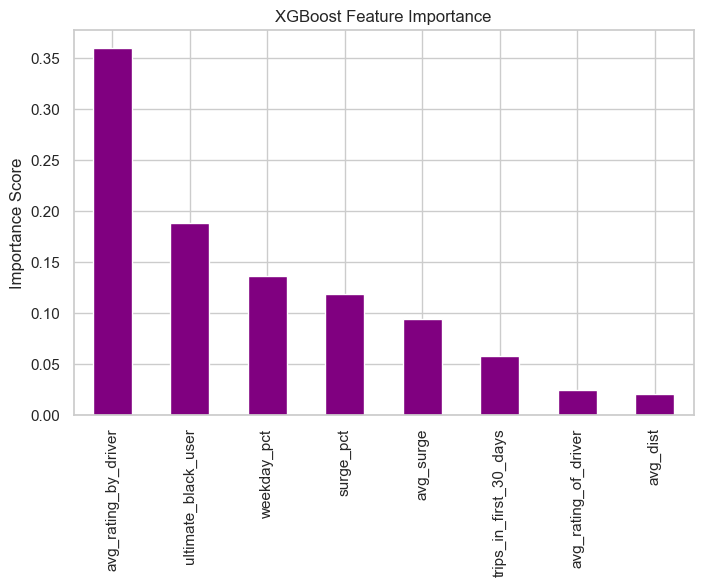

In [21]:
importances = pd.Series(
    xgb.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importances.plot(kind='bar', color='purple')
plt.title("XGBoost Feature Importance")
plt.ylabel("Importance Score")
plt.show()


Key Drivers of Retention:

Average rating by driver

ultimate_black_user

weekday_pct

surge_pct

avg_surge

trips_in_first_30_days

avg_rating_of_driver

avg_dist


Rider retention is driven primarily by early service quality and habit formation. Users who receive strong driver ratings, engage with premium offerings, and incorporate the service into regular weekday usage are significantly more likely to remain active. Pricing tolerance and early engagement volume further reinforce long-term retention by signaling higher perceived value.